In [6]:
import math

def generate_primes(n: int) -> list[int]:
    is_prime = [True] * n
    is_prime[0] = is_prime[1] = False  # 0 and 1 are not prime numbers

    primes = []
    for p in range(2, n):
        if is_prime[p]:
            primes.append(p)
            # Mark all multiples of p as not prime
            for i in range(p * p, n, p):
                is_prime[i] = False
    return primes

limit = 5000000
prime_list = generate_primes(limit)

# print(f"List of primes less than {limit}:", prime_list)
print(f"Number of primes less than {limit}:", len(prime_list))

Number of primes less than 5000000: 348513


In [7]:
import numpy as np
from numba import njit
import tqdm

# Find the number of the mod-p solutions to the equation y^2 = x^a + b
@njit
def count_solutions_hyperelliptic_curve(a, b, p):
    v_x = np.arange(p)
    v_x = (v_x ** a + b) % p
    res_x = np.bincount(v_x, minlength = p)
    
    v_y = np.arange(p)
    v_y = (v_y ** 2) % p
    res_y = np.bincount(v_y, minlength = p)
    return sum(res_x * res_y)

data = []
for prime in tqdm.tqdm(prime_list):
    sols = count_solutions_hyperelliptic_curve(5, -1, prime)
    error = (prime + 1 - sols) / (2 * 2 * pow(prime, (1/2)))
    if error < -1:
        error = -1
    if error > 1:
        error = 1
    angle = math.acos(error)
    data.append((prime, sols, error, angle))

# print("[prime, number of solutions of y^2 = x^5 - 1 mod prime, error, angle]:", data)

100%|█████████████████████████████████| 348513/348513 [3:24:30<00:00, 28.40it/s]


In [9]:
len(data)

348513

In [10]:
print(type(data))

<class 'list'>


In [15]:
import math
import numpy as np
import pandas as pd
import tqdm
import bisect

sorted_data = sorted(data, key=lambda x: x[3])

num = 5000
data_to_process = []
for r in tqdm.tqdm(np.linspace(0, math.pi, num + 1)):
    data_to_process.append((r, 1/math.pi * r, bisect.bisect_right([d[3] for d in sorted_data], r)/len(data)))


columns = ['Right', 'Tot', 'Target']
df = pd.DataFrame(data_to_process, columns=columns)

print(df)

100%|███████████████████████████████████████| 5001/5001 [01:25<00:00, 58.18it/s]

         Right     Tot    Target
0     0.000000  0.0000  0.000055
1     0.000628  0.0002  0.000055
2     0.001257  0.0004  0.000055
3     0.001885  0.0006  0.000055
4     0.002513  0.0008  0.000055
...        ...     ...       ...
4996  3.139079  0.9992  0.999954
4997  3.139708  0.9994  0.999954
4998  3.140336  0.9996  0.999954
4999  3.140964  0.9998  0.999954
5000  3.141593  1.0000  1.000000

[5001 rows x 3 columns]


In [17]:
num = 5000
data_to_process_with_error1 = []
for r in tqdm.tqdm(np.linspace(0, math.pi, num + 1)):
    e = - math.sin(r) * math.cos(r)
    data_to_process_with_error1.append((r, 1/math.pi * (r + e), bisect.bisect_right([d[3] for d in sorted_data], r)/len(data)))

df_error1 = pd.DataFrame(data_to_process_with_error1, columns=columns)

print(df_error1)

100%|███████████████████████████████████████| 5001/5001 [01:33<00:00, 53.68it/s]

         Right           Tot    Target
0     0.000000  0.000000e+00  0.000055
1     0.000628  5.263789e-11  0.000055
2     0.001257  4.211030e-10  0.000055
3     0.001885  1.421222e-09  0.000055
4     0.002513  3.368821e-09  0.000055
...        ...           ...       ...
4996  3.139079  1.000000e+00  0.999954
4997  3.139708  1.000000e+00  0.999954
4998  3.140336  1.000000e+00  0.999954
4999  3.140964  1.000000e+00  0.999954
5000  3.141593  1.000000e+00  1.000000

[5001 rows x 3 columns]


In [18]:
df.describe()

,Right,Tot,Target
count,5001.000000,5001.000000,5001.000000
mean,1.570796,0.500000,0.499927
std,0.907172,0.288762,0.450246
min,0.000000,0.000000,0.000055
25%,0.785398,0.250000,0.002889
50%,1.570796,0.500000,0.499522
75%,2.356194,0.750000,0.997085
max,3.141593,1.000000,1.000000


In [19]:
df_error1.describe()

,Right,Tot,Target
count,5001.000000,5001.000000,5001.000000
mean,1.570796,0.500000,0.499927
std,0.907172,0.383026,0.450246
min,0.000000,0.000000,0.000055
25%,0.785398,0.090845,0.002889
50%,1.570796,0.500000,0.499522
75%,2.356194,0.909155,0.997085
max,3.141593,1.000000,1.000000


Linear Regression Mean Squared Error (MSE): 0.025514524969857393
R-squared (R2) Score: 0.875334395679876
Linear Regression Mean Absolute Error (MAE): 0.14118689371373885


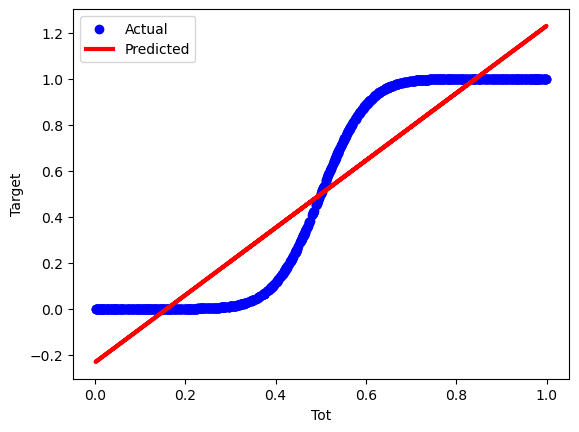

In [66]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X = df[['Tot']]  
y = df['Target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred_linear = linear_reg.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"Linear Regression Mean Squared Error (MSE): {mse_linear}")
print(f"R-squared (R2) Score: {r2_linear}")
print(f"Linear Regression Mean Absolute Error (MAE): {mae_linear}")

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred_linear, linewidth=3, color='red', label='Predicted')
plt.xlabel('Tot')
plt.ylabel('Target')
plt.legend()
plt.show()

In [67]:
slope_linear = linear_reg.coef_
intercept_linear = linear_reg.intercept_

print("Linear Regression Coefficient:", slope_linear[0])
print("Linear Regression Intercept", intercept_linear)

Linear Regression Coefficient: 1.4619627588275081
Linear Regression Intercept -0.23286169836115078


In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

# Set the range of polynomial degrees to consider
degrees = np.arange(1, 100)

# Perform k-fold cross-validation for each degree
k_folds = 10
cv_scores = []
poly_mse = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Take the mean of the negative mean squared errors
    poly_mse.append([degree, -scores.mean()])

# print("[degree, average MSE]:", poly_mse)

# Find the degree with the lowest cross-validation error
best_degree = degrees[np.argmin(cv_scores)]
print(f"\nThe best degree of polynomial features is {best_degree} with average MSE {poly_mse[best_degree][1]}")


The best degree of polynomial features is 94 with average MSE 2.0001783358206167e-08


Polynomial Regression of degree 94 MSE: 2.3228032660218343e-08
Polynomial Regression of degree 94 MAE: 0.00011433422112858046
R-squared (R2) Score: 0.9999998865063436


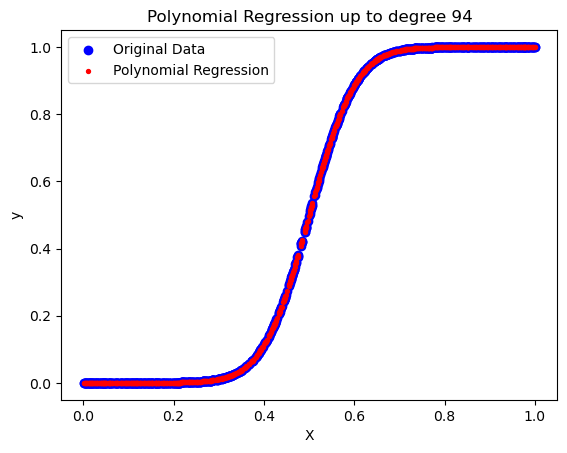

In [69]:
# Train the final model with the best degree
final_poly_reg = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
final_poly_reg.fit(X_train, y_train)

y_pred_poly = final_poly_reg.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
print(f"Polynomial Regression of degree {best_degree} MSE: {mse_poly}")
print(f"Polynomial Regression of degree {best_degree} MAE: {mae_poly}")
print(f"R-squared (R2) Score: {r2_poly}")

# Plot the original data and the polynomial regression model
plt.scatter(X_test, y_test, color='blue', label='Original Data')
plt.scatter(X_test, y_pred_poly, s=8, color='red', label='Polynomial Regression')
plt.title(f"Polynomial Regression up to degree {best_degree}")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

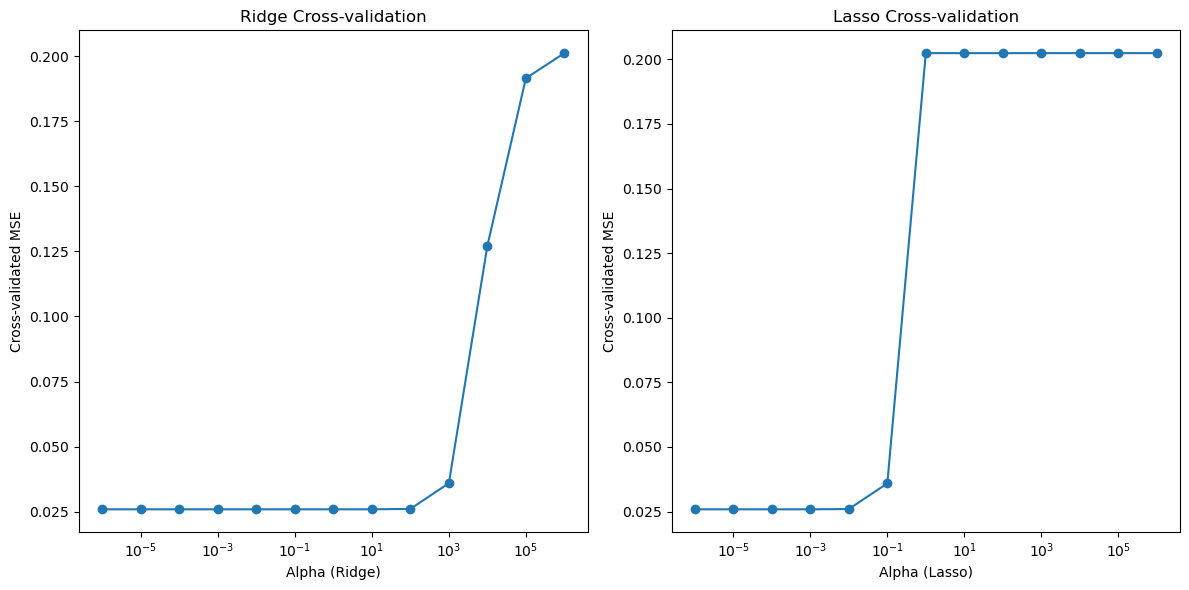

In [70]:
from sklearn.linear_model import Lasso, Ridge

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Define a range of alpha values for regularization strength
alphas = np.logspace(-6, 6, 13)

# Cross-validation for Ridge regression
ridge_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_scores.append(-np.mean(scores))

# Cross-validation for Lasso regression
lasso_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_scores.append(-np.mean(scores))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Ridge)')
plt.ylabel('Cross-validated MSE')
plt.title('Ridge Cross-validation')

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Lasso)')
plt.ylabel('Cross-validated MSE')
plt.title('Lasso Cross-validation')

plt.tight_layout()
plt.show()

Ridge Regression MSE: 0.02551433224044284
Lasso Regression MSE: 0.026261738081670594


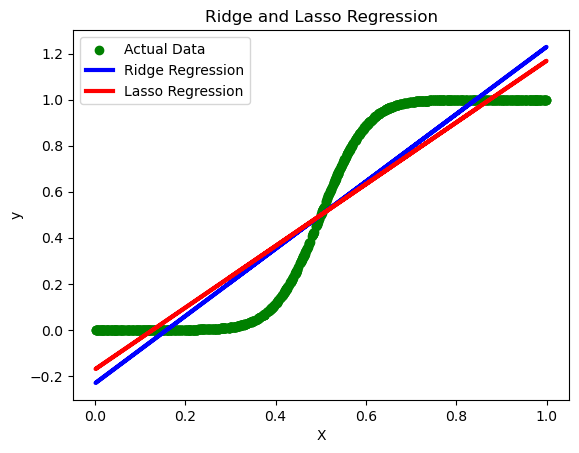

In [71]:
# from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
alpha_ridge = 0.01  # Regularization strength (hyperparameter)

ridge_reg = Ridge(alpha=alpha_ridge)
ridge_reg.fit(X_train, y_train)

# Lasso Regression
alpha_lasso = 0.01  # Regularization strength (hyperparameter)

lasso_reg = Lasso(alpha=alpha_lasso)
lasso_reg.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)

# Evaluate the models
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Ridge Regression MSE:", mse_ridge)
print("Lasso Regression MSE:", mse_lasso)

# Plot the results
plt.scatter(X_test, y_test, color='green', label='Actual Data')
plt.plot(X_test, y_pred_ridge, linewidth=3, color='blue', label='Ridge Regression')
plt.plot(X_test, y_pred_lasso, linewidth=3, color='red', label='Lasso Regression')
plt.title('Ridge and Lasso Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [72]:
# Get the slope (coefficient) for Ridge regression
slope_ridge = ridge_reg.coef_
intercept_ridge = ridge_reg.intercept_

print("Ridge Regression Coefficient:", slope_ridge[0])
print("Ridge Regression Intercept:", intercept_ridge)

# Get the slope (coefficient) for Lasso regression
slope_lasso = lasso_reg.coef_
intercept_lasso = lasso_reg.intercept_

print("Lasso Regression Coefficient:", slope_lasso[0])
print("Lasso Regression Intercept:", intercept_lasso)

Ridge Regression Coefficient: 1.461918463830408
Ridge Regression Intercept: -0.23283947717122866
Lasso Regression Coefficient: 1.3407658570943362
Lasso Regression Intercept: -0.17206161826899635


Learning Rate: 0.001, Average MSE: 0.16577905964480572
Learning Rate: 0.01, Average MSE: 0.027302160189693097
Learning Rate: 0.1, Average MSE: 2.110482571775738e-06
Learning Rate: 0.2, Average MSE: 3.0248879042619363e-06
Learning Rate: 0.5, Average MSE: 1.0782296503095364e-06
Learning Rate: 1, Average MSE: 7.631210413593865e-07
Learning Rate: 2, Average MSE: 0.2023836976134367

Best Learning Rate: 1
Gradient Boosting Regression MSE: 7.118388440610488e-07
R-squared (R2) Score: 0.9999965219097836


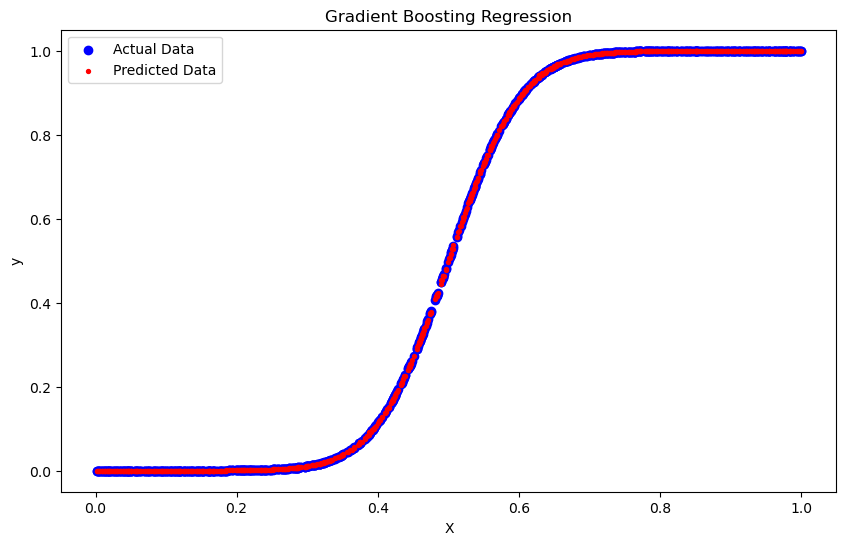

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2]

# Cross-validation for Gradient Boosted Regressor with different learning rates
avg_mse = []
for learning_rate in learning_rates:
    gb_regressor = GradientBoostingRegressor(learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(gb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    avg_mse.append(avg_score)
    print(f"Learning Rate: {learning_rate}, Average MSE: {avg_score}")

# Choose the learning rate with the best performance
best_learning_rate = learning_rates[np.argmin(avg_mse)]
print(f"\nBest Learning Rate: {best_learning_rate}")

# Train the final model using the best learning rate on the entire training set
final_gb_regressor = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)
final_gb_regressor.fit(X_train, y_train)
y_pred_fgb = final_gb_regressor.predict(X_test)

mse_fgb = mean_squared_error(y_test, y_pred_fgb)
r2_fgb = r2_score(y_test, y_pred_fgb)  # = final_gb_regressor.score(X_test, y_test)

print("Gradient Boosting Regression MSE:", mse_fgb)
print("R-squared (R2) Score:", r2_fgb)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_fgb, s=8, color='red', label='Predicted Data')
plt.title("Gradient Boosting Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [64]:
conda install -c conda-forge xgboost

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/wangxiyuan/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.11.0              |  py311h267d04e_1         1.2 MB  conda-forge
    libcxx-16.0.6              |       h4653b0c_0         1.1 MB  conda-forge
    libexpat-2.5.0             |       hb7217d7_1          62 KB  conda-forge
    libsqlite-3.44.2           |       h091b4b1_0         796 KB  conda-forge
    libxgboost-2.0.3           |   cpu_h40478aa_0         1.5 MB  conda-forge
    libzlib-1.2.13             |       h53f4e23_5          47 KB  conda-forge
    llvm-openmp-17.0.6         |       hcd81f8e_0         268 KB  conda-forge
    py-xgboost-2.0.3           |cpu_py311hd2f5cba_0         358 KB  conda-forge
    python-3.11.7              |

In [63]:
conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /Users/wangxiyuan/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          13 KB
    abseil-cpp-20230802.0      |       h313beb8_2         1.3 MB
    aiobotocore-2.7.0          |  py311hca03da5_0         154 KB
    aiohttp-3.9.0              |  py311h80987f9_0         795 KB
    anaconda-cloud-auth-0.1.4  |  py311hca03da5_0          39 KB
    archspec-0.2.1             |     pyhd3eb1b0_0          39 KB
    astropy-5.3.4              |  py311hb9f6ed7_0         9.8 MB
    async-lru-2.0.4            |  py311hca03da5_0          22 KB
    black-23.11.0              |  py311hca03da5_0         364 KB
    bokeh-3.3.0                |  py311hb6e6a13_0         5.7 MB
    boost-cpp-1.82.0           |       h48ca7d4_2          12 KB
  

dask-2023.11.0       | 6 KB      | ##################################### | 100% [A


jupyter_server_termi | 28 KB     | ##################################### | 100% 

partd-1.4.1          | 49 KB     | ##################################### | 100% 




grpc-cpp-1.48.2      | 3.0 MB    | ####4                                 |  12% 





pyqt-5.15.10         | 4.3 MB    | ##5                                   |   7% 



holoviews-1.18.1     | 5.1 MB    | #####2                                |  14% 
conda-23.11.0        | 1.3 MB    | #######################               |  62% 






_py-xgboost-mutex-2. | 13 KB     | ##################################### | 100% 






_py-xgboost-mutex-2. | 13 KB     | ##################################### | 100% 







cytoolz-0.12.2       | 368 KB    | #6                                    |   4% 








botocore-1.31.64     | 7.0 MB    |                                       |   0% 




grpc-cpp-1.48.2      | 3.0 MB    | ####################5     

menuinst-2.0.1       | 167 KB    | ##################################### | 100% 






















 ... (more hidden) ...






















 ... (more hidden) ...





















pycosat-0.6.6        | 88 KB     | ##################################### | 100% 





















pycosat-0.6.6        | 88 KB     | ##################################### | 100% 













distributed-2023.11. | 1.7 MB    | ##################################### | 100% 












pandas-2.1.4         | 14.3 MB   | #############################2        |  79% 


















datashader-0.16.0    | 17.1 MB   | ########5                             |  23% 












pandas-2.1.4         | 14.3 MB   | ####################################6 |  99% 


















datashader-0.16.0    | 17.1 MB   | ##########1                           |  27% 


















datashader-0.16.0    | 17.1 MB   | ############                          |  32% 


















datashader-0.16.0    | 17.1 MB

Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


Learning Rate: 0.001, Average MSE: 0.16578731463706084
Learning Rate: 0.01, Average MSE: 0.02729860586454646
Learning Rate: 0.1, Average MSE: 5.487091060693879e-06
Learning Rate: 0.2, Average MSE: 5.552111209180482e-06
Learning Rate: 0.5, Average MSE: 5.638656233801903e-06
Learning Rate: 1, Average MSE: 5.569227989680485e-06
Learning Rate: 2, Average MSE: 0.12620279344598195

Best Learning Rate: 0.1
XGBoost Regression MSE: 4.999044325641178e-06
R-squared (R2) Score: 0.9999755743490183


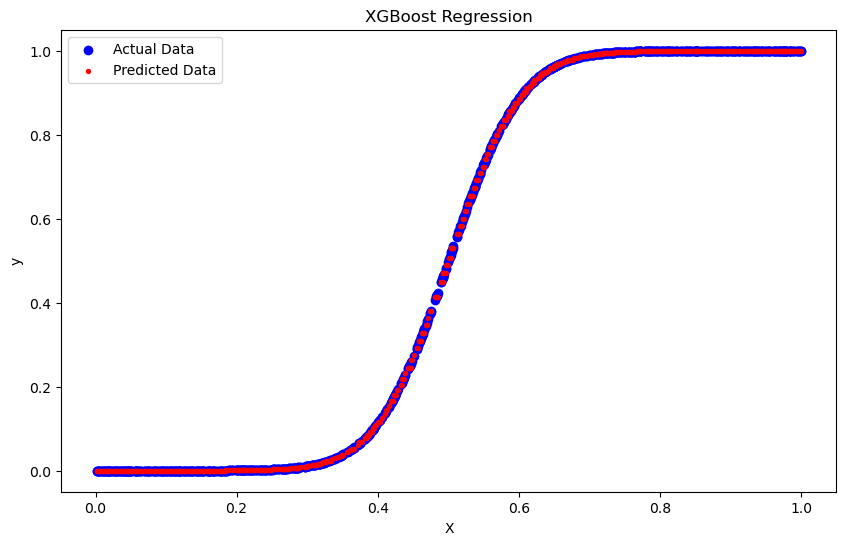

In [74]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2]

# Cross-validation for XGBoost Regressor with different learning rates
avg_mse = []
for learning_rate in learning_rates:
    xgb_regressor = xgb.XGBRegressor(learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    avg_mse.append(avg_score)
    print(f"Learning Rate: {learning_rate}, Average MSE: {avg_score}")

# Choose the learning rate with the best performance
best_learning_rate = learning_rates[np.argmin(avg_mse)]
print(f"\nBest Learning Rate: {best_learning_rate}")

# Train the final model using the best learning rate on the entire training set
final_xgb_regressor = xgb.XGBRegressor(learning_rate=best_learning_rate, random_state=42)
final_xgb_regressor.fit(X_train, y_train)
y_pred_xgb = final_xgb_regressor.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)  # = final_xgb_regressor.score(X_test, y_test)

print("XGBoost Regression MSE:", mse_xgb)
print("R-squared (R2) Score:", r2_xgb)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_xgb, s=8, color='red', label='Predicted Data')
plt.title("XGBoost Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Linear Regression Mean Squared Error (MSE): 0.008148545695490257
R-squared (R2) Score: 0.9601856834623201
Linear Regression Mean Absolute Error (MAE): 0.07804454925238954


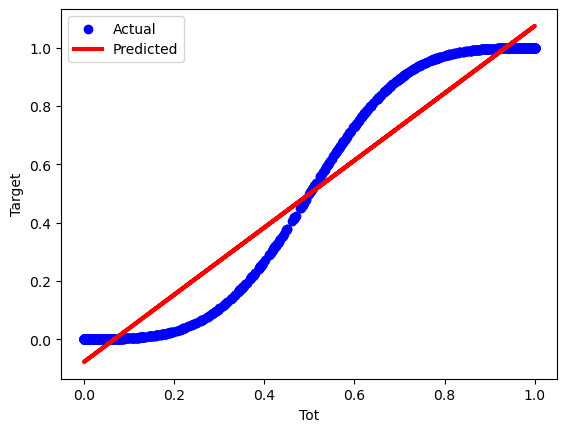

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X = df_error1[['Tot']]  
y = df_error1['Target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred_linear = linear_reg.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print(f"Linear Regression Mean Squared Error (MSE): {mse_linear}")
print(f"R-squared (R2) Score: {r2_linear}")
print(f"Linear Regression Mean Absolute Error (MAE): {mae_linear}")

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred_linear, linewidth=3, color='red', label='Predicted')
plt.xlabel('Tot')
plt.ylabel('Target')
plt.legend()
plt.show()

In [78]:
slope_linear = linear_reg.coef_
intercept_linear = linear_reg.intercept_

print("Linear Regression Coefficient:", slope_linear[0])
print("Linear Regression Intercept", intercept_linear)

Linear Regression Coefficient: 1.152608528621693
Linear Regression Intercept -0.07759368075949591


In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

# Set the range of polynomial degrees to consider
degrees = np.arange(1, 100)

# Perform k-fold cross-validation for each degree
k_folds = 10
cv_scores = []
poly_mse = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Take the mean of the negative mean squared errors
    poly_mse.append([degree, -scores.mean()])

# print("[degree, average MSE]:", poly_mse)

# Find the degree with the lowest cross-validation error
best_degree = degrees[np.argmin(cv_scores)]
print(f"\nThe best degree of polynomial features is {best_degree} with average MSE {poly_mse[best_degree][1]}")


The best degree of polynomial features is 58 with average MSE 1.0624380007837967e-08


Polynomial Regression of degree 58 MSE: 8.920924456600078e-09
Polynomial Regression of degree 58 MAE: 5.0664443024000394e-05
R-squared (R2) Score: 0.9999999564117913


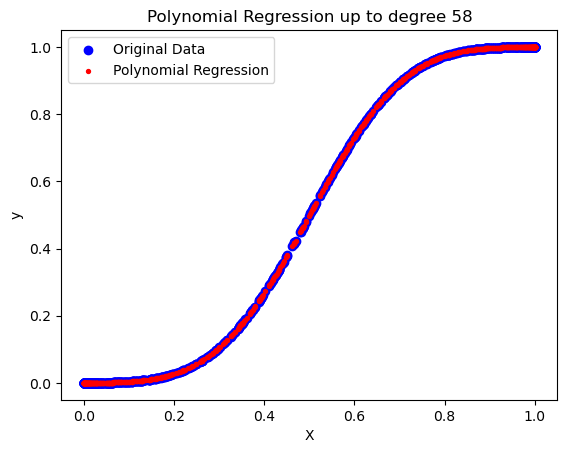

In [80]:
# Train the final model with the best degree
final_poly_reg = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
final_poly_reg.fit(X_train, y_train)

y_pred_poly = final_poly_reg.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
print(f"Polynomial Regression of degree {best_degree} MSE: {mse_poly}")
print(f"Polynomial Regression of degree {best_degree} MAE: {mae_poly}")
print(f"R-squared (R2) Score: {r2_poly}")

# Plot the original data and the polynomial regression model
plt.scatter(X_test, y_test, color='blue', label='Original Data')
plt.scatter(X_test, y_pred_poly, s=8, color='red', label='Polynomial Regression')
plt.title(f"Polynomial Regression up to degree {best_degree}")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

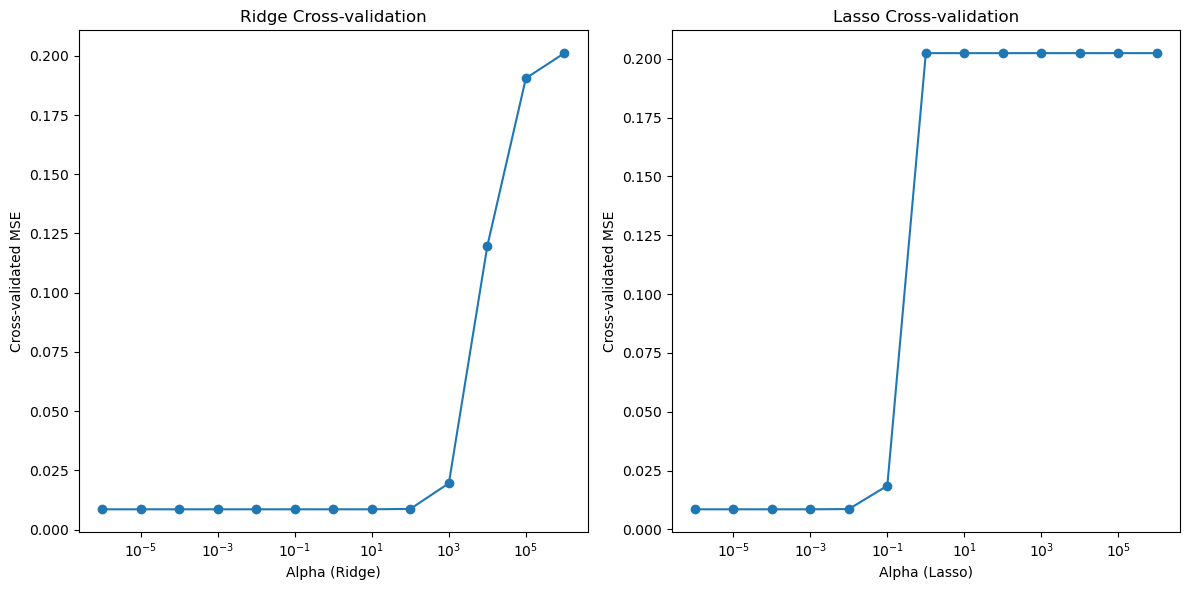

In [81]:
from sklearn.linear_model import Lasso, Ridge

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Define a range of alpha values for regularization strength
alphas = np.logspace(-6, 6, 13)

# Cross-validation for Ridge regression
ridge_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_scores.append(-np.mean(scores))

# Cross-validation for Lasso regression
lasso_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_scores.append(-np.mean(scores))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Ridge)')
plt.ylabel('Cross-validated MSE')
plt.title('Ridge Cross-validation')

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Lasso)')
plt.ylabel('Cross-validated MSE')
plt.title('Lasso Cross-validation')

plt.tight_layout()
plt.show()

Ridge Regression MSE: 0.008148491982563176
Lasso Regression MSE: 0.008669122034150632


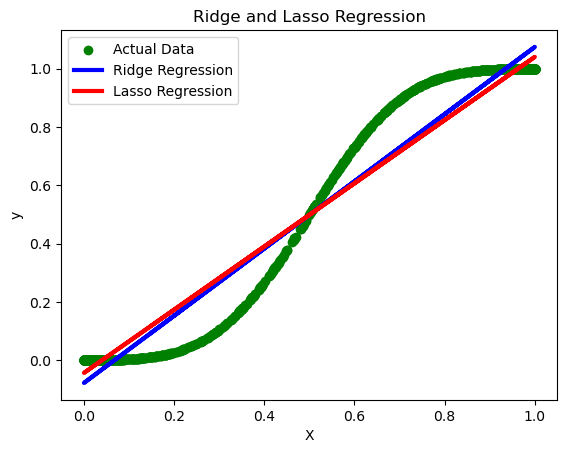

In [82]:
# from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
alpha_ridge = 0.01  # Regularization strength (hyperparameter)

ridge_reg = Ridge(alpha=alpha_ridge)
ridge_reg.fit(X_train, y_train)

# Lasso Regression
alpha_lasso = 0.01  # Regularization strength (hyperparameter)

lasso_reg = Lasso(alpha=alpha_lasso)
lasso_reg.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)

# Evaluate the models
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Ridge Regression MSE:", mse_ridge)
print("Lasso Regression MSE:", mse_lasso)

# Plot the results
plt.scatter(X_test, y_test, color='green', label='Actual Data')
plt.plot(X_test, y_pred_ridge, linewidth=3, color='blue', label='Ridge Regression')
plt.plot(X_test, y_pred_lasso, linewidth=3, color='red', label='Lasso Regression')
plt.title('Ridge and Lasso Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [83]:
# Get the slope (coefficient) for Ridge regression
slope_ridge = ridge_reg.coef_
intercept_ridge = ridge_reg.intercept_

print("Ridge Regression Coefficient:", slope_ridge[0])
print("Ridge Regression Intercept:", intercept_ridge)

# Get the slope (coefficient) for Lasso regression
slope_lasso = lasso_reg.coef_
intercept_lasso = lasso_reg.intercept_

print("Lasso Regression Coefficient:", slope_lasso[0])
print("Lasso Regression Intercept:", intercept_lasso)

Ridge Regression Coefficient: 1.152588762674535
Ridge Regression Intercept: -0.07758376620982121
Lasso Regression Coefficient: 1.084011825983228
Lasso Regression Intercept: -0.04318574622443261


Learning Rate: 0.001, Average MSE: 0.1657746384986873
Learning Rate: 0.01, Average MSE: 0.02729267564006881
Learning Rate: 0.1, Average MSE: 2.119487182721442e-06
Learning Rate: 0.2, Average MSE: 3.0626382042870876e-06
Learning Rate: 0.5, Average MSE: 1.0820718876576467e-06
Learning Rate: 1, Average MSE: 7.563497189920313e-07
Learning Rate: 2, Average MSE: 0.2023836976134367

Best Learning Rate: 1
Gradient Boosting Regression MSE: 6.940365132476027e-07
R-squared (R2) Score: 0.999996608893113


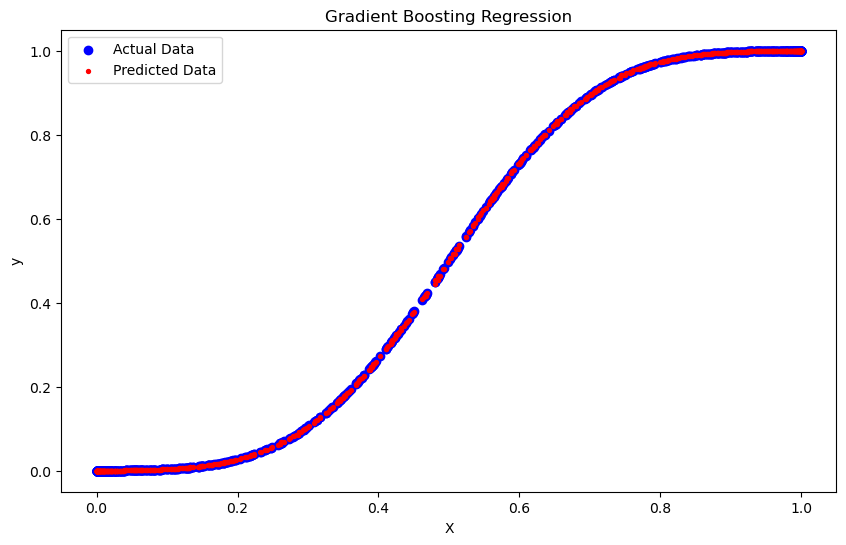

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2]

# Cross-validation for Gradient Boosted Regressor with different learning rates
avg_mse = []
for learning_rate in learning_rates:
    gb_regressor = GradientBoostingRegressor(learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(gb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    avg_mse.append(avg_score)
    print(f"Learning Rate: {learning_rate}, Average MSE: {avg_score}")

# Choose the learning rate with the best performance
best_learning_rate = learning_rates[np.argmin(avg_mse)]
print(f"\nBest Learning Rate: {best_learning_rate}")

# Train the final model using the best learning rate on the entire training set
final_gb_regressor = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)
final_gb_regressor.fit(X_train, y_train)
y_pred_fgb = final_gb_regressor.predict(X_test)

mse_fgb = mean_squared_error(y_test, y_pred_fgb)
r2_fgb = r2_score(y_test, y_pred_fgb)  # = final_gb_regressor.score(X_test, y_test)

print("Gradient Boosting Regression MSE:", mse_fgb)
print("R-squared (R2) Score:", r2_fgb)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_fgb, s=8, color='red', label='Predicted Data')
plt.title("Gradient Boosting Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

Learning Rate: 0.001, Average MSE: 0.16579004736425504
Learning Rate: 0.01, Average MSE: 0.02728894553219515
Learning Rate: 0.1, Average MSE: 5.363098779183561e-06
Learning Rate: 0.2, Average MSE: 5.4378029353627436e-06
Learning Rate: 0.5, Average MSE: 5.574737837589909e-06
Learning Rate: 1, Average MSE: 5.5935560614386655e-06
Learning Rate: 2, Average MSE: 0.12511945862583038

Best Learning Rate: 0.1
XGBoost Regression MSE: 5.00741231090445e-06
R-squared (R2) Score: 0.9999755334625059


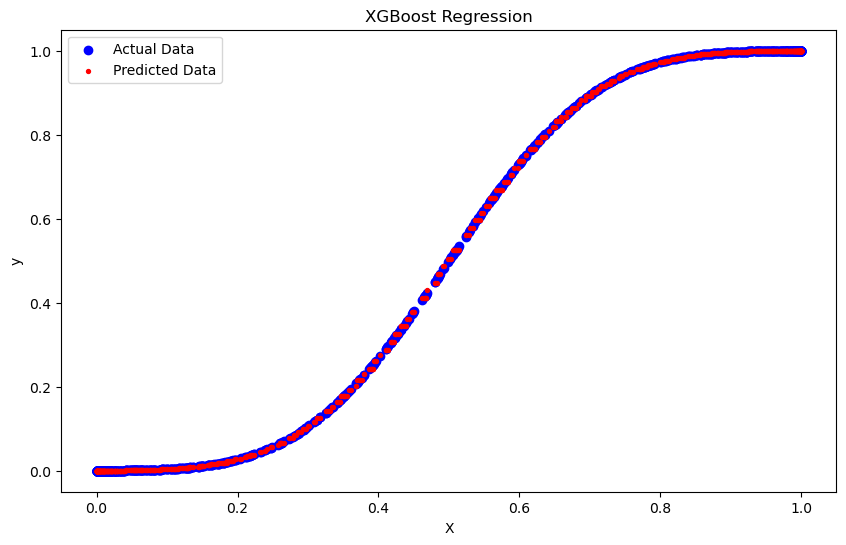

In [85]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2]

# Cross-validation for XGBoost Regressor with different learning rates
avg_mse = []
for learning_rate in learning_rates:
    xgb_regressor = xgb.XGBRegressor(learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    avg_mse.append(avg_score)
    print(f"Learning Rate: {learning_rate}, Average MSE: {avg_score}")

# Choose the learning rate with the best performance
best_learning_rate = learning_rates[np.argmin(avg_mse)]
print(f"\nBest Learning Rate: {best_learning_rate}")

# Train the final model using the best learning rate on the entire training set
final_xgb_regressor = xgb.XGBRegressor(learning_rate=best_learning_rate, random_state=42)
final_xgb_regressor.fit(X_train, y_train)
y_pred_xgb = final_xgb_regressor.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)  # = final_xgb_regressor.score(X_test, y_test)

print("XGBoost Regression MSE:", mse_xgb)
print("R-squared (R2) Score:", r2_xgb)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_xgb, s=8, color='red', label='Predicted Data')
plt.title("XGBoost Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()